In [1]:
import pyspark as ps
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType, IntegerType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer, HashingTF, StandardScaler
from pyspark.ml.feature import StopWordsRemover
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

In [2]:
spark = (
    ps.sql.SparkSession.builder
    .master("local[4]")
    .appName("project")
    .getOrCreate()
)

sc = spark.sparkContext

In [3]:
df = spark.read.json("ten_users1.json")
df = df.where(df['author'].isin(['dntletmygfknowimhere','Colin03129', 'jl_theprofessor', 'myKidsLike2Scream', 'a_frayn','QuoteMasterLT','glackbuy99']))

In [4]:
df1, df2 = df.randomSplit([0.5, 0.5])

In [5]:
df2.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        311|
|          Colin03129|        397|
|     jl_theprofessor|       2659|
|   myKidsLike2Scream|        661|
|             a_frayn|       1022|
|       QuoteMasterLT|       1577|
|          glackbuy99|        478|
+--------------------+-----------+



In [6]:
df1.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        327|
|          Colin03129|        359|
|     jl_theprofessor|       2685|
|   myKidsLike2Scream|        607|
|             a_frayn|       1063|
|       QuoteMasterLT|       1548|
|          glackbuy99|        524|
+--------------------+-----------+



In [7]:
comments1 = df1.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df1_join_comments = comments1.withColumn('corpus', join_comments_udf(comments1['collect_list(body)']))

In [8]:
def count_links(s):
    num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
    return num_links
count_links_udf = udf(count_links, IntegerType())
df_count_links1 = df1_join_comments.withColumn(
    'link_count', count_links_udf(df1_join_comments['corpus']))


In [9]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links1 = df_count_links1.withColumn('corpus', drop_links_udf(df_count_links1['corpus']))

In [10]:
df_drop_links1.show(5)

+--------------------+--------------------+--------------------+----------+
|              author|  collect_list(body)|              corpus|link_count|
+--------------------+--------------------+--------------------+----------+
|dntletmygfknowimhere|[

Pro: making

C...|

Pro: making

Co...|         1|
|          Colin03129|[###Environmental...|###Environmental ...|         1|
|     jl_theprofessor|[


The WAU is Ir...|


The WAU is Irr...|         1|
|   myKidsLike2Scream|["...we'll be tak...|"...we'll be taki...|         1|
|             a_frayn|[ http://i.imgur....| http://i.imgur.c...|         1|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [11]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens1 = df_drop_links1.withColumn('tokens', tokenize_udf(df_drop_links1['corpus']))

In [12]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words1 = df_tokens1.withColumn('words', find_words_udf(df_tokens1['tokens']))

In [13]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df1 = df_find_words1.withColumn('word_lengths', word_length_udf(df_find_words1['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df1 = word_length_df1.withColumn('total_words', total_words_udf(word_length_df1['words']))

In [14]:
total_words_df1.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|dntletmygfknowimhere|[

Pro: making

C...|

Pro: making

Co...|         1|[pro, :, making, ...|[pro, making, con...|[3, 6, 3, 4, 3, 2...|       6368|
|          Colin03129|[###Environmental...|###Environmental ...|         1|[###environmental...|[protection, envi...|[10, 13, 7, 3, 8,...|       8397|
|     jl_theprofessor|[


The WAU is Ir...|


The WAU is Irr...|         1|[the, wau, is, ir...|[the, wau, is, ir...|[3, 3, 2, 12, 5, ...|      61319|
|   myKidsLike2Scream|["...we'll be tak...|"...we'll be taki...|         1|[", ..., we'll, b..

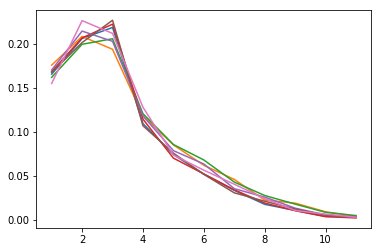

In [15]:
MCCC1 = total_words_df1.select('author', 'word_lengths', 'total_words')
word_freqs1 = {}
for i in MCCC1.rdd.collect():
    x = []
    y = []
    for k, v in (dict(nltk.FreqDist(i[1]))).items():
        x.append(k)
        y.append(v / i[2])
    idx = np.argsort(x)[1:12]
    z = np.array(y)[idx]
    plt.plot(range(1,12), z)
    word_freqs1[i[0]] = z

In [16]:
word_freqs1

{'dntletmygfknowimhere': array([0.16535804, 0.20587312, 0.21843593, 0.10913945, 0.07396357,
        0.05182161, 0.03329146, 0.0174309 , 0.01052136, 0.00376884,
        0.00329774]),
 'Colin03129': array([0.17565797, 0.20828867, 0.19364059, 0.11789925, 0.08503037,
        0.06180779, 0.04573062, 0.02226986, 0.01881624, 0.00893176,
        0.00369179]),
 'jl_theprofessor': array([0.16172801, 0.19935094, 0.20564588, 0.12043575, 0.08540583,
        0.06784194, 0.04272738, 0.02747925, 0.01767804, 0.00836609,
        0.00468044]),
 'myKidsLike2Scream': array([0.16830986, 0.20657277, 0.2221831 , 0.11420188, 0.06995305,
        0.05199531, 0.03392019, 0.01889671, 0.01021127, 0.00340376,
        0.00199531]),
 'a_frayn': array([0.17018763, 0.2143296 , 0.20270334, 0.11786946, 0.07845361,
        0.06328276, 0.03525686, 0.02566284, 0.01309136, 0.00543504,
        0.00250484]),
 'QuoteMasterLT': array([0.16728994, 0.20129718, 0.22665654, 0.10669627, 0.07561061,
        0.05147832, 0.03050134, 0.02

In [17]:
comments2 = df2.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df2_join_comments = comments2.withColumn('corpus', join_comments_udf(comments2['collect_list(body)']))

In [18]:
def count_links(s):
    num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
    return num_links
count_links_udf = udf(count_links, IntegerType())
df_count_links2 = df2_join_comments.withColumn(
    'link_count', count_links_udf(df2_join_comments['corpus']))


In [19]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links2 = df_count_links2.withColumn('corpus', drop_links_udf(df_count_links2['corpus']))

In [20]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens2 = df_drop_links2.withColumn('tokens', tokenize_udf(df_drop_links2['corpus']))

In [21]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words2 = df_tokens2.withColumn('words', find_words_udf(df_tokens2['tokens']))

In [22]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df2 = df_find_words2.withColumn('word_lengths', word_length_udf(df_find_words2['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df2 = word_length_df2.withColumn('total_words', total_words_udf(word_length_df2['words']))

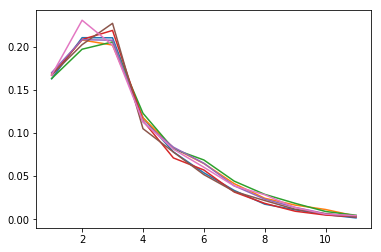

In [23]:
MCCC2 = total_words_df2.select('author', 'word_lengths', 'total_words')
word_freqs2 = {}
for i in MCCC2.rdd.collect():
    x = []
    y = []
    for k, v in (dict(nltk.FreqDist(i[1]))).items():
        x.append(k)
        y.append(v / i[2])
    idx = np.argsort(x)[1:12]
    z = np.array(y)[idx]
    plt.plot(range(1,12), z)
    word_freqs2[i[0]] = z

In [24]:
word_freqs1

{'dntletmygfknowimhere': array([0.16535804, 0.20587312, 0.21843593, 0.10913945, 0.07396357,
        0.05182161, 0.03329146, 0.0174309 , 0.01052136, 0.00376884,
        0.00329774]),
 'Colin03129': array([0.17565797, 0.20828867, 0.19364059, 0.11789925, 0.08503037,
        0.06180779, 0.04573062, 0.02226986, 0.01881624, 0.00893176,
        0.00369179]),
 'jl_theprofessor': array([0.16172801, 0.19935094, 0.20564588, 0.12043575, 0.08540583,
        0.06784194, 0.04272738, 0.02747925, 0.01767804, 0.00836609,
        0.00468044]),
 'myKidsLike2Scream': array([0.16830986, 0.20657277, 0.2221831 , 0.11420188, 0.06995305,
        0.05199531, 0.03392019, 0.01889671, 0.01021127, 0.00340376,
        0.00199531]),
 'a_frayn': array([0.17018763, 0.2143296 , 0.20270334, 0.11786946, 0.07845361,
        0.06328276, 0.03525686, 0.02566284, 0.01309136, 0.00543504,
        0.00250484]),
 'QuoteMasterLT': array([0.16728994, 0.20129718, 0.22665654, 0.10669627, 0.07561061,
        0.05147832, 0.03050134, 0.02

In [25]:
#find RMSE for each of the users
word_lengths = {}
for key, value in word_freqs1.items():
    error_values = {}
    for k, v in word_freqs2.items():
        rmse = np.mean(np.sqrt((v-value)**2))
        error_values[k] = rmse
    word_lengths[key] = error_values

In [26]:
word_lengths

{'dntletmygfknowimhere': {'dntletmygfknowimhere': 0.0030415574489097443,
  'Colin03129': 0.007232809414484562,
  'jl_theprofessor': 0.008962843649411339,
  'myKidsLike2Scream': 0.0020878993589796527,
  'a_frayn': 0.005536804331713035,
  'QuoteMasterLT': 0.0028537407947247548,
  'glackbuy99': 0.007668906664840056},
 'Colin03129': {'dntletmygfknowimhere': 0.007094167725391774,
  'Colin03129': 0.0030001517422287237,
  'jl_theprofessor': 0.005509181308394059,
  'myKidsLike2Scream': 0.008153599327053375,
  'a_frayn': 0.0041590397691140335,
  'QuoteMasterLT': 0.009367181116347045,
  'glackbuy99': 0.00651988185554512},
 'jl_theprofessor': {'dntletmygfknowimhere': 0.00668470388711838,
  'Colin03129': 0.003452422002464113,
  'jl_theprofessor': 0.0013576856573640427,
  'myKidsLike2Scream': 0.008454504079201976,
  'a_frayn': 0.004263740050613655,
  'QuoteMasterLT': 0.008680802900150048,
  'glackbuy99': 0.006575814423450375},
 'myKidsLike2Scream': {'dntletmygfknowimhere': 0.0036062111612501337,
  

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame(word_lengths)

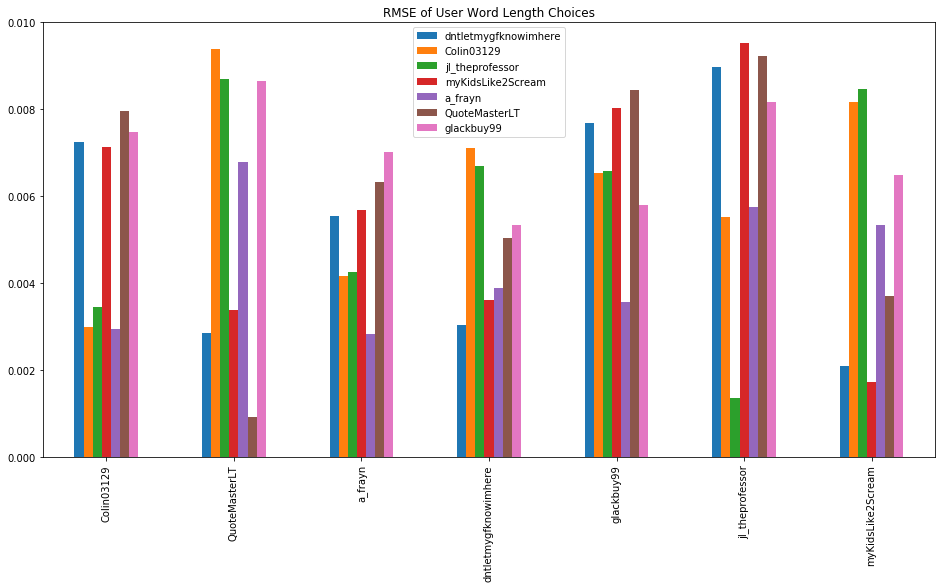

In [41]:
ax = df.plot(kind='bar', figsize=(16,8), title='RMSE of User Word Length Choices')
fig = ax.get_figure()
fig.savefig('word_length_errors.png')


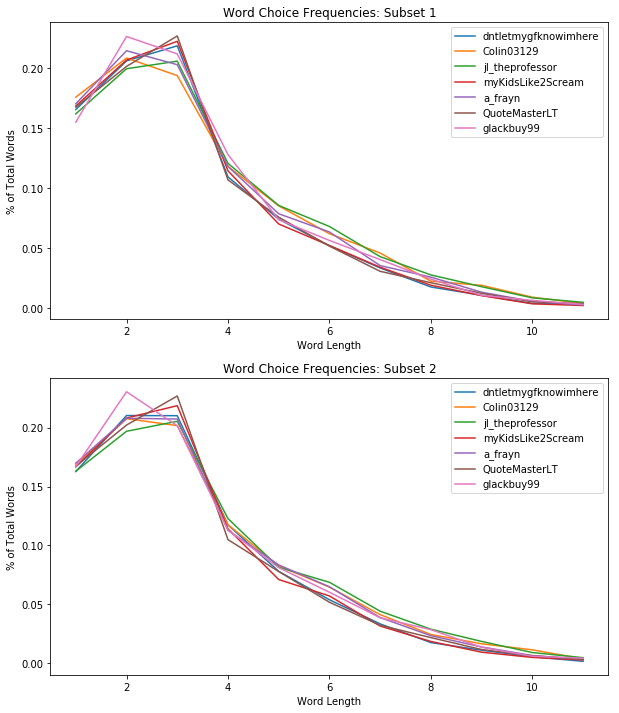

In [40]:
fig, ax = plt.subplots(2,1,figsize=(10,12))
for key, value in word_freqs1.items():
    ax[0].plot(range(1,12), value, label=key)
ax[0].set_ylabel('% of Total Words')
ax[0].set_xlabel('Word Length')
ax[0].set_title('Word Choice Frequencies: Subset 1')
ax[0].legend()
for key, value in word_freqs2.items():
    ax[1].plot(range(1,12), value, label=key)
ax[1].set_ylabel('% of Total Words')
ax[1].set_xlabel('Word Length')
ax[1].set_title('Word Choice Frequencies: Subset 2')
ax[1].legend()
fig.savefig('word_lengths.png', bbox_inches='tight')